In [2]:
import pandas as pd
import pickle
import networkx as nx
import numpy as np
import geopandas as gpd
import math

from matplotlib import pyplot as plt
from tqdm import tqdm
from utils import *

In [6]:
# Hyper-parameters 

# Round up to 5 decimal place to avoid mismatch due to mathematical precision
round_decimals = pd.Series(data=5, index=['start_latitude','start_longitude', 'end_latitude', 'end_longitude'])

# Range of neighborhood
range = 5

In [7]:
df_xd_to_tmc = pd.read_csv("./xd_to_tmc_v2.csv")

# Incident Data (Both TMC & XD)
old_col = list(np.load("../../data/old/old_col.npy", allow_pickle=True))  # 1008 (369 tti, 315 inc, 303 sd, 21 weather & time)
set_inc_segments = set([i[4:] for i in old_col if "inc" in i]) # 315 TMC & XD incident segments, 273 TMC and 15 XD in geometry data

## 1. Get Upstream and Downstream TMC Segments

1. Select TMC 
2. Calculate immediate prev and next neighbors for each TMC segment using their starting & ending positions
    - If there is multiple prev or next, store as a list
3. Calculate upstream and downstream neighbors for each TMC segment using their immediate prev and next
    - If there is multiple prev or next, the endpoint is a splitting point, we should split into several results 

### 1.1 Select TMC Segments

In [11]:
# TMC Speed Data
'''
Columns:
    'tmc_code', 'measurement_tstamp', 'speed', 'average_speed',
    'reference_speed', 'travel_time_minutes', 'confidence_score', 'cvalue'
'''
df_spd_tmc_all = pd.read_csv("../../data/speed/cranberry_tmc_1min/downsampled_cran_tmc_1min_all.csv") # 1000 tmc (106627081,8)
set_spd_tmc_segments = set(df_spd_tmc_all.tmc_code.unique()).union(set(df_xd_to_tmc.id_tmc.unique())) # 1000 segments covered in speed data, all are included in geometry data

In [12]:
# TMC Shapefile
gdf_shp_tmc = gpd.read_file("../../data/shape/tmc_shape_cranberry/tmc_cranberry_v2_with_direction.geojson")  # id and geometry of 1037 unique tmc segments in cranberry shape file, 1000 of which are covered in "set_spd_tmc_segments" and 273 are covered in "set_inc_segments"; shape (1037, 16) 
gdf_shp_tmc = gdf_shp_tmc.rename(columns={"tmc":"id_tmc"})
gdf_shp_tmc = gdf_shp_tmc.round(decimals=round_decimals)  # round up to 5 decimal place to avoid mismatch due to mathematical precision, e.g. I missed "104-06225" and "104-06224" previously due to unaligned mathematical precisions.

set_shp_tmc_segments = set(gdf_shp_tmc.id_tmc.unique()) # 1037 tmc segments covered in shapefile

In [13]:
# 1000 TMC segments covered in speed data and shapefile
set_tmc_segments_within_spd_shp = set_spd_tmc_segments.intersection(set_shp_tmc_segments)

# 273 TMC segments covered in speed data, shapefile and inc data
set_tmc_segments_within_spd_shp_inc = set_tmc_segments_within_spd_shp.intersection(set_inc_segments) 

In [7]:
with open("./set_tmc_segments_within_spd_shp.pkl", "wb") as f:
    pickle.dump(set_tmc_segments_within_spd_shp, f)

In [8]:
with open("./set_tmc_segments_within_spd_shp_inc.pkl", "wb") as f:
    pickle.dump(set_tmc_segments_within_spd_shp_inc, f)

<AxesSubplot: title={'center': 'Visualization of 1037 Cranberry TMC Segments (Grey), where 273 have both Speed AND Incident Data (Green)'}>

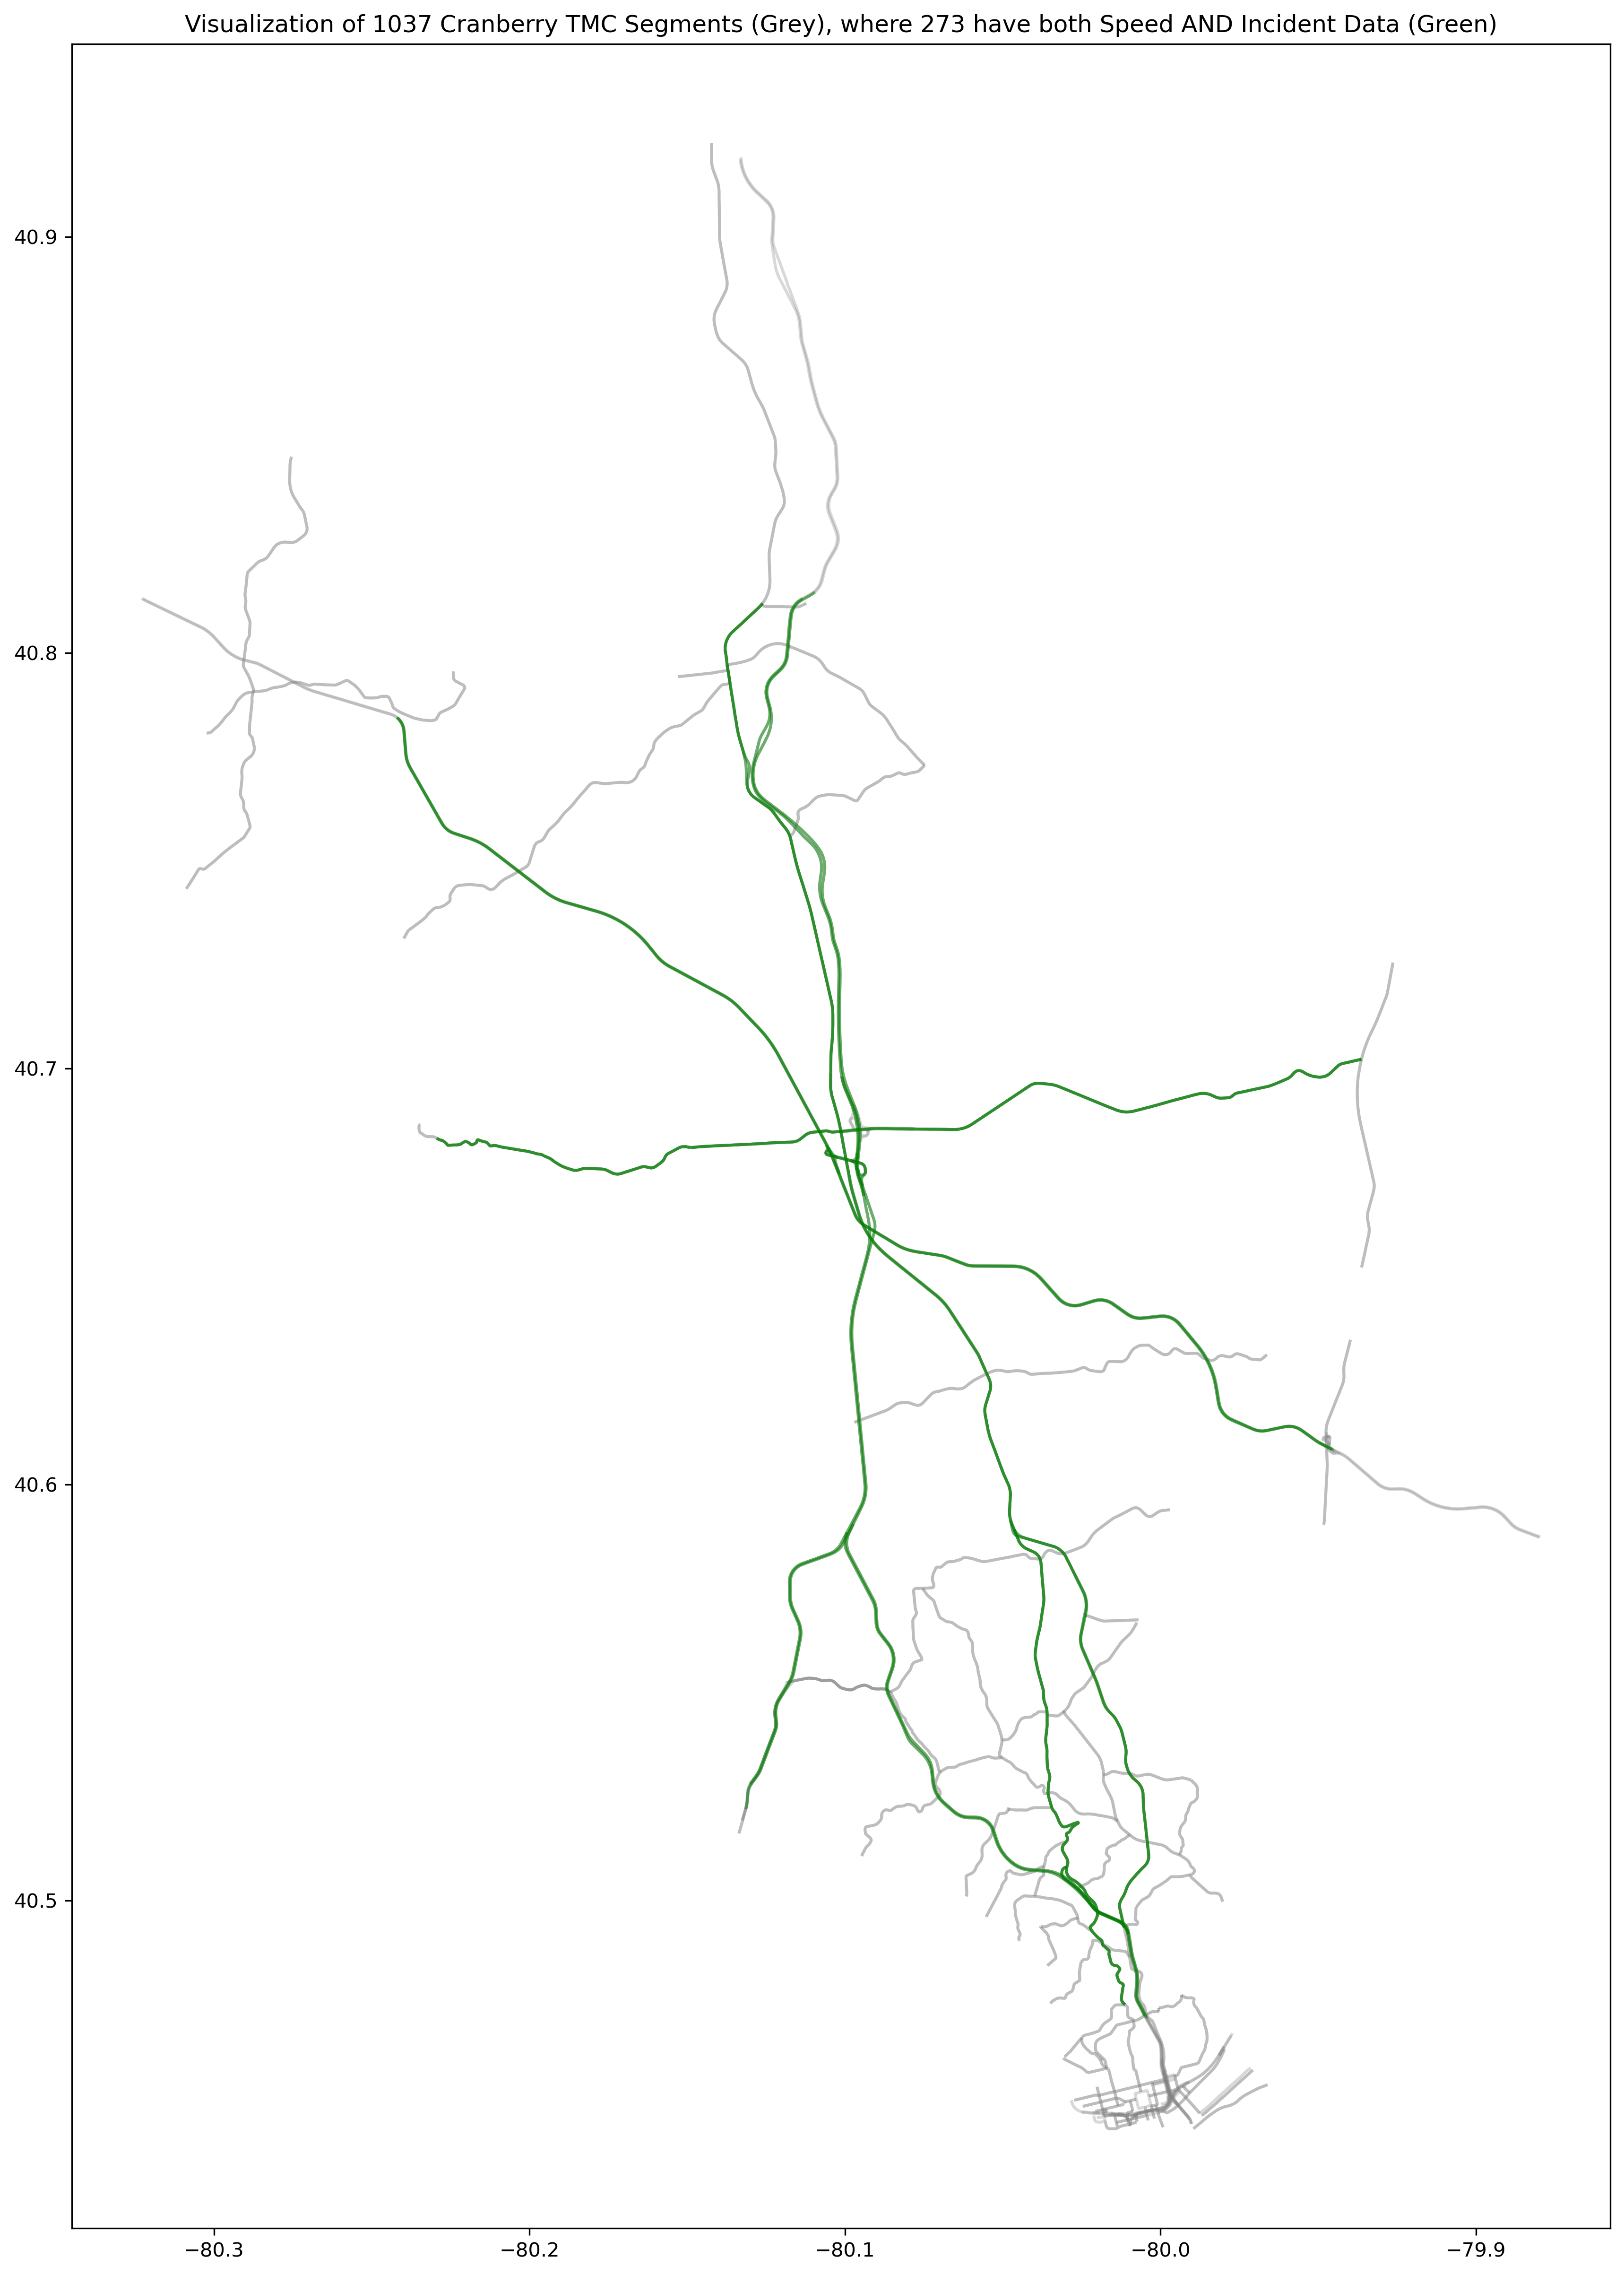

In [9]:
# Visualize TMC segments covered in different sources
fig, ax = plt.subplots(1,figsize=(30,20), dpi=300)
ax.set_title("Visualization of 1037 Cranberry TMC Segments (Grey), where 273 have both Speed AND Incident Data (Green)")
gdf_shp_tmc.plot(ax=ax, color="grey", alpha=0.3)
# gdf_tmc_cranberry[gdf_tmc_cranberry.id_tmc.isin(set_tmc_segments_within_spd_shp)].plot(ax=ax, color="blue", alpha=0.5)
gdf_shp_tmc[gdf_shp_tmc.id_tmc.isin(set_tmc_segments_within_spd_shp_inc)].plot(ax=ax, color="green", alpha=0.5)

In [10]:
gdf_shp_tmc

,id_tmc,miles,direction,type_x,type_y,road_order,roadname,roadnumber,county,state,zip,start_latitude,start_longitude,end_latitude,end_longitude,geometry
0,104N50571,0.021407,WESTBOUND,P1.11,Feature,1.0,STOCKTON AVE,None,ALLEGHENY,PA,15212,40.45088,-80.00097,40.45080,-80.00136,"MULTILINESTRING ((-80.00097 40.45088, -80.0010..."
1,104-51195,0.598167,SOUTHBOUND,P1.11,Feature,1.0,MAIRDALE ST,None,ALLEGHENY,PA,15214,40.48972,-80.01866,40.48529,-80.02506,"MULTILINESTRING ((-80.01866 40.48972, -80.0187..."
2,104N16196,0.023896,WESTBOUND,P1.11,Feature,1.0,W NEW CASTLE ST,PA-288,BUTLER,PA,16063,40.79575,-80.13706,40.79569,-80.13751,"MULTILINESTRING ((-80.13706 40.79575, -80.1375..."
3,104N14097,0.013589,WESTBOUND,P1.11,Feature,1.0,MARTINDALE ST,None,ALLEGHENY,PA,15212,40.44899,-80.01016,40.44892,-80.01040,"MULTILINESTRING ((-80.01016 40.44899, -80.0102..."
4,104N13509,0.085117,SOUTHBOUND,P1.11,Feature,1.0,BABCOCK BLVD,None,ALLEGHENY,PA,15237,40.55455,-80.02125,40.55347,-80.02202,"MULTILINESTRING ((-80.02125 40.55455, -80.0213..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1032,104P06682,0.256086,NORTHBOUND,P1.3,Feature,730.0,PERRY HWY,US-19,BUTLER,PA,16063,40.77100,-80.13045,40.77453,-80.13130,"MULTILINESTRING ((-80.13045 40.77100, -80.1304..."
1033,104+06683,1.277890,NORTHBOUND,P1.11,Feature,731.0,S MAIN ST,US-19,BUTLER,PA,16063,40.77453,-80.13130,40.79256,-80.13640,"MULTILINESTRING ((-80.13130 40.77453, -80.1314..."
1034,104+06684,1.528426,NORTHBOUND,P1.11,Feature,732.0,PERRY HWY,US-19,BUTLER,PA,16037,40.79256,-80.13640,40.81121,-80.12685,"MULTILINESTRING ((-80.13640 40.79256, -80.1364..."
1035,104P06684,0.059670,NORTHBOUND,P1.11,Feature,733.0,PERRY HWY,US-19,BUTLER,PA,16037,40.81121,-80.12685,40.81188,-80.12613,"MULTILINESTRING ((-80.12685 40.81121, -80.1264..."


In [11]:
dict_miles_tmc = dict(gdf_shp_tmc[["id_tmc", "miles"]].values)
with open("./dict_miles_tmc_for_upstream.pkl", "wb") as f:
    pickle.dump(dict_miles_tmc, f)

### 1.2 Calculate immediate prev and next neighbors for each TMC segment using their starting & ending positions

#### 1.2.1 Previous Segment

In [12]:
# Step 1. Join starting and ending positions
df_raw_prev_tmc_1073 = pd.merge(left=gdf_shp_tmc, right=gdf_shp_tmc, left_on=["start_latitude", "start_longitude"], right_on=["end_latitude", "end_longitude"], how="left") # shape (2001, 32)

# Select 273 starting TMC segments (covered in shapefile, speed data and incident data)
# Also, the prev neighbor segments of those 273 starting TMC segments should be covered in shapefile and speed data
df_raw_prev_tmc_273 = df_raw_prev_tmc_1073[(df_raw_prev_tmc_1073.id_tmc_x.isin(set_tmc_segments_within_spd_shp_inc)) & (df_raw_prev_tmc_1073.id_tmc_y.isin(set_tmc_segments_within_spd_shp))] # includes 273 starting TMC segments matched with 299 prev neighbors, shape (439, 32)

In [13]:
# It's noted that entries in "direction" column is not "clean"
# We will take care of them in manual checking of direction/angle.
df_raw_prev_tmc_273.direction_x.unique()  

array(['SOUTHBOUND', 'WESTBOUND', 'EASTBOUND', 'I-79',
       'I-79 AND US-19/PERRY HWY',
       'I-76/PENNSYLVANIA TPKE AND I-79 SB AND US-19/PERRY HWY SB',
       'I-76/PENNSYLVANIA TPKE AND US-19 SB AND PA-228/MARS CRIDER RD',
       'I-76/PENNSYLVANIA TPKE', 'NORTHBOUND',
       'I-79 SOUTHBOUND AND US-19/PERRY HWY'], dtype=object)

In [14]:
# Step 2. Compute angle  
df_raw_prev_tmc_273["angle"] = df_raw_prev_tmc_273.apply(lambda x: angle_neighbor(x.geometry_x, x.geometry_y), axis=1)

/var/folders/y2/1kk0np3x01qchz21plxx_m0w0000gn/T/ipykernel_2975/1589548212.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw_prev_tmc_273["angle"] = df_raw_prev_tmc_273.apply(lambda x: angle_neighbor(x.geometry_x, x.geometry_y), axis=1)


In [15]:
# summary of angle
df_raw_prev_tmc_273.angle.describe()

count    439.000000
mean       0.315102
std        0.427903
min        0.000000
25%        0.007735
50%        0.025102
75%        0.953549
max        1.000000
Name: angle, dtype: float64

In [16]:
# remove those in the same road but opposite directions
df_raw_prev_tmc_273_checked_angle = df_raw_prev_tmc_273[df_raw_prev_tmc_273.angle < 0.75] # 272 starting TMC segments, (323, 33)

In [17]:
# summary of angle
df_raw_prev_tmc_273_checked_angle.angle.describe()

count    323.000000
mean       0.072006
std        0.155556
min        0.000000
25%        0.005152
50%        0.012840
75%        0.034333
max        0.743292
Name: angle, dtype: float64

<AxesSubplot: title={'center': 'Visualization of 1037 Cranberry TMC Segments (Grey), where 272 have neighbors within angle of 0.75*pi'}>

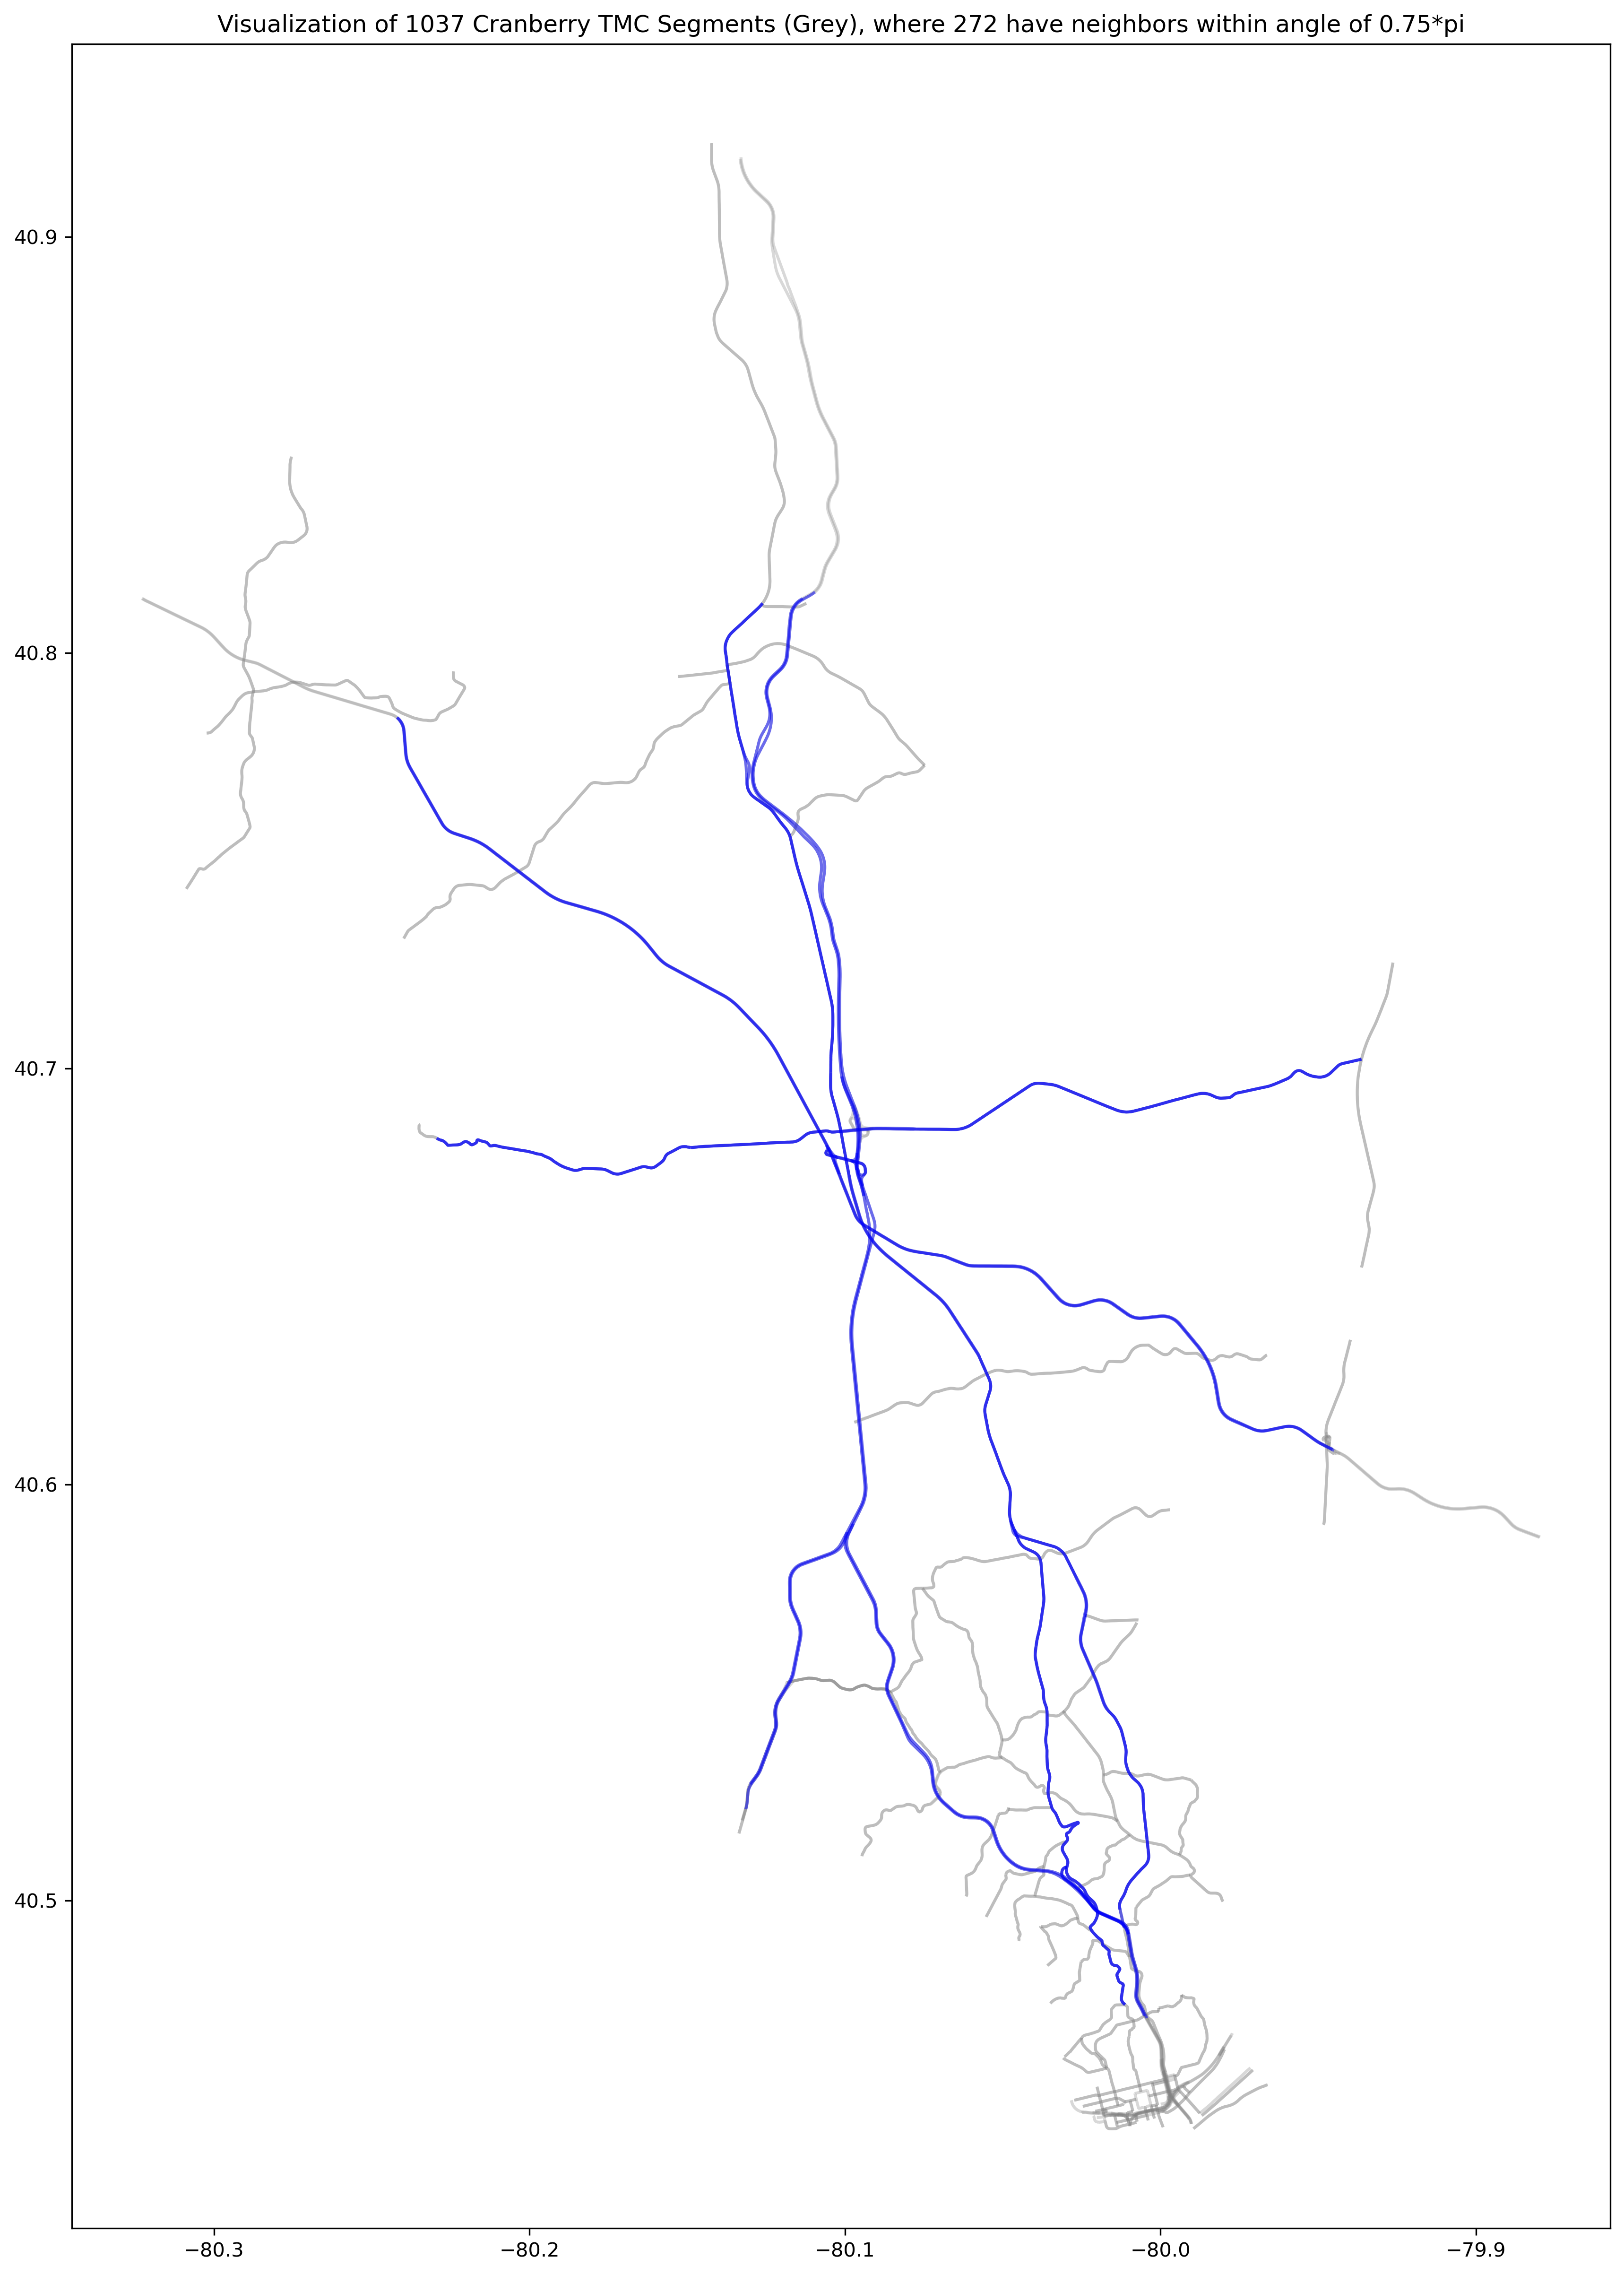

In [18]:
# Visualize 913 TMC segments that have neighbors within angle of 0.75*pi
fig, ax = plt.subplots(1,figsize=(30,20), dpi=300)
ax.set_title("Visualization of 1037 Cranberry TMC Segments (Grey), where 272 have neighbors within angle of 0.75*pi")
gdf_shp_tmc.plot(ax=ax, color="grey", alpha=0.3)
gdf_shp_tmc[gdf_shp_tmc.id_tmc.isin(set(df_raw_prev_tmc_273_checked_angle.id_tmc_x.unique()))].plot(ax=ax, color="blue", alpha=0.5)

In [19]:
# Step 3. output raw csv file for manual checking in QGIS
df_raw_prev_tmc_273_checked_angle.to_csv("./raw_prev_tmc_v2.csv", index=False)  # 1169 pairs, 601 of which have angle > 0.1

# I have decided not to auto-check direction, but manually chceck directions, as there are cases where neighbors can have opposite directions.
# df_raw_prev_tmc["direction_matchness"] = df_raw_prev_tmc.apply(lambda x: check_direction(x.direction_x, x.direction_y), axis=1)
# df_raw_prev_tmc = df_raw_prev_tmc[df_raw_prev_tmc.direction_matchness == 1].reset_index(drop=True) # includes 884 TMC segments, shape (1131, 34) 

In [14]:
# Step 4. Load manually checked immediate previous segments
df_prev_tmc = pd.read_csv("./prev_tmc_v2.csv")
df_prev_tmc = df_prev_tmc[["id_tmc_x", "id_tmc_y"]].groupby("id_tmc_x").agg(tuple).applymap(list).reset_index()
df_prev_tmc.columns = ["id_tmc", "prev_tmc"] # shape (272, 2)

In [15]:
df_prev_tmc_multiple = df_prev_tmc[df_prev_tmc.prev_tmc.map(len) > 1]  # there are 40 TMC segments which have more than one immediate neighbors

starting segment: 104-09195
prev segments: ['104-09196', '104P04637']


<AxesSubplot: >

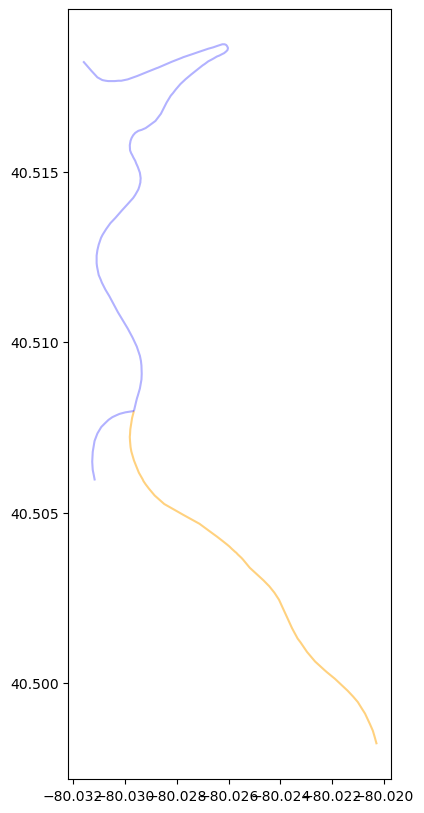

In [16]:
# Visualize and manually check intermediate calculation of previous neighbors
'''
 0,   1,   3,   6,  16,  22,  26,  47,  50,  52,  61,  63,  65, 
 66,  69,  73,  78,  88, 108, 121, 123, 132, 134, 136, 137, 139,
145, 166, 169, 184, 189, 193, 199, 200, 204, 233, 238, 244, 259, 270
'''
i = 22
check_curr_tmc = df_prev_tmc_multiple.iloc[i].id_tmc
check_prev_tmc = df_prev_tmc_multiple.iloc[i].prev_tmc
print(f"starting segment: {check_curr_tmc}")
print(f"prev segments: {check_prev_tmc}")
# print(gdf_tmc_cranberry[gdf_tmc_cranberry.id_tmc.isin(check_prev_tmc)])
fig, ax = plt.subplots(1,figsize=(10,10), dpi=100)
# gdf_tmc_cranberry.plot(ax=ax, color="grey", alpha=0.3)
gdf_shp_tmc[gdf_shp_tmc.id_tmc == check_curr_tmc].plot(ax=ax, color="orange", alpha=0.5)  # starting segment
gdf_shp_tmc[gdf_shp_tmc.id_tmc.isin(check_prev_tmc)].plot(ax=ax, color="blue", alpha=0.3)  # prev neighbors

In [17]:
# Convert dataframe to dictionary to be saved later
dict_prev_tmc = dict(df_prev_tmc.values) # contains 272 tmc segments, 40 of which have more than one immediate prev neighbor

{'104P04638'}


<AxesSubplot: title={'center': "273 Target TMC Segments (grey), where 272 (blue) have prev neighbors and 1 segment (red) doesn't"}>

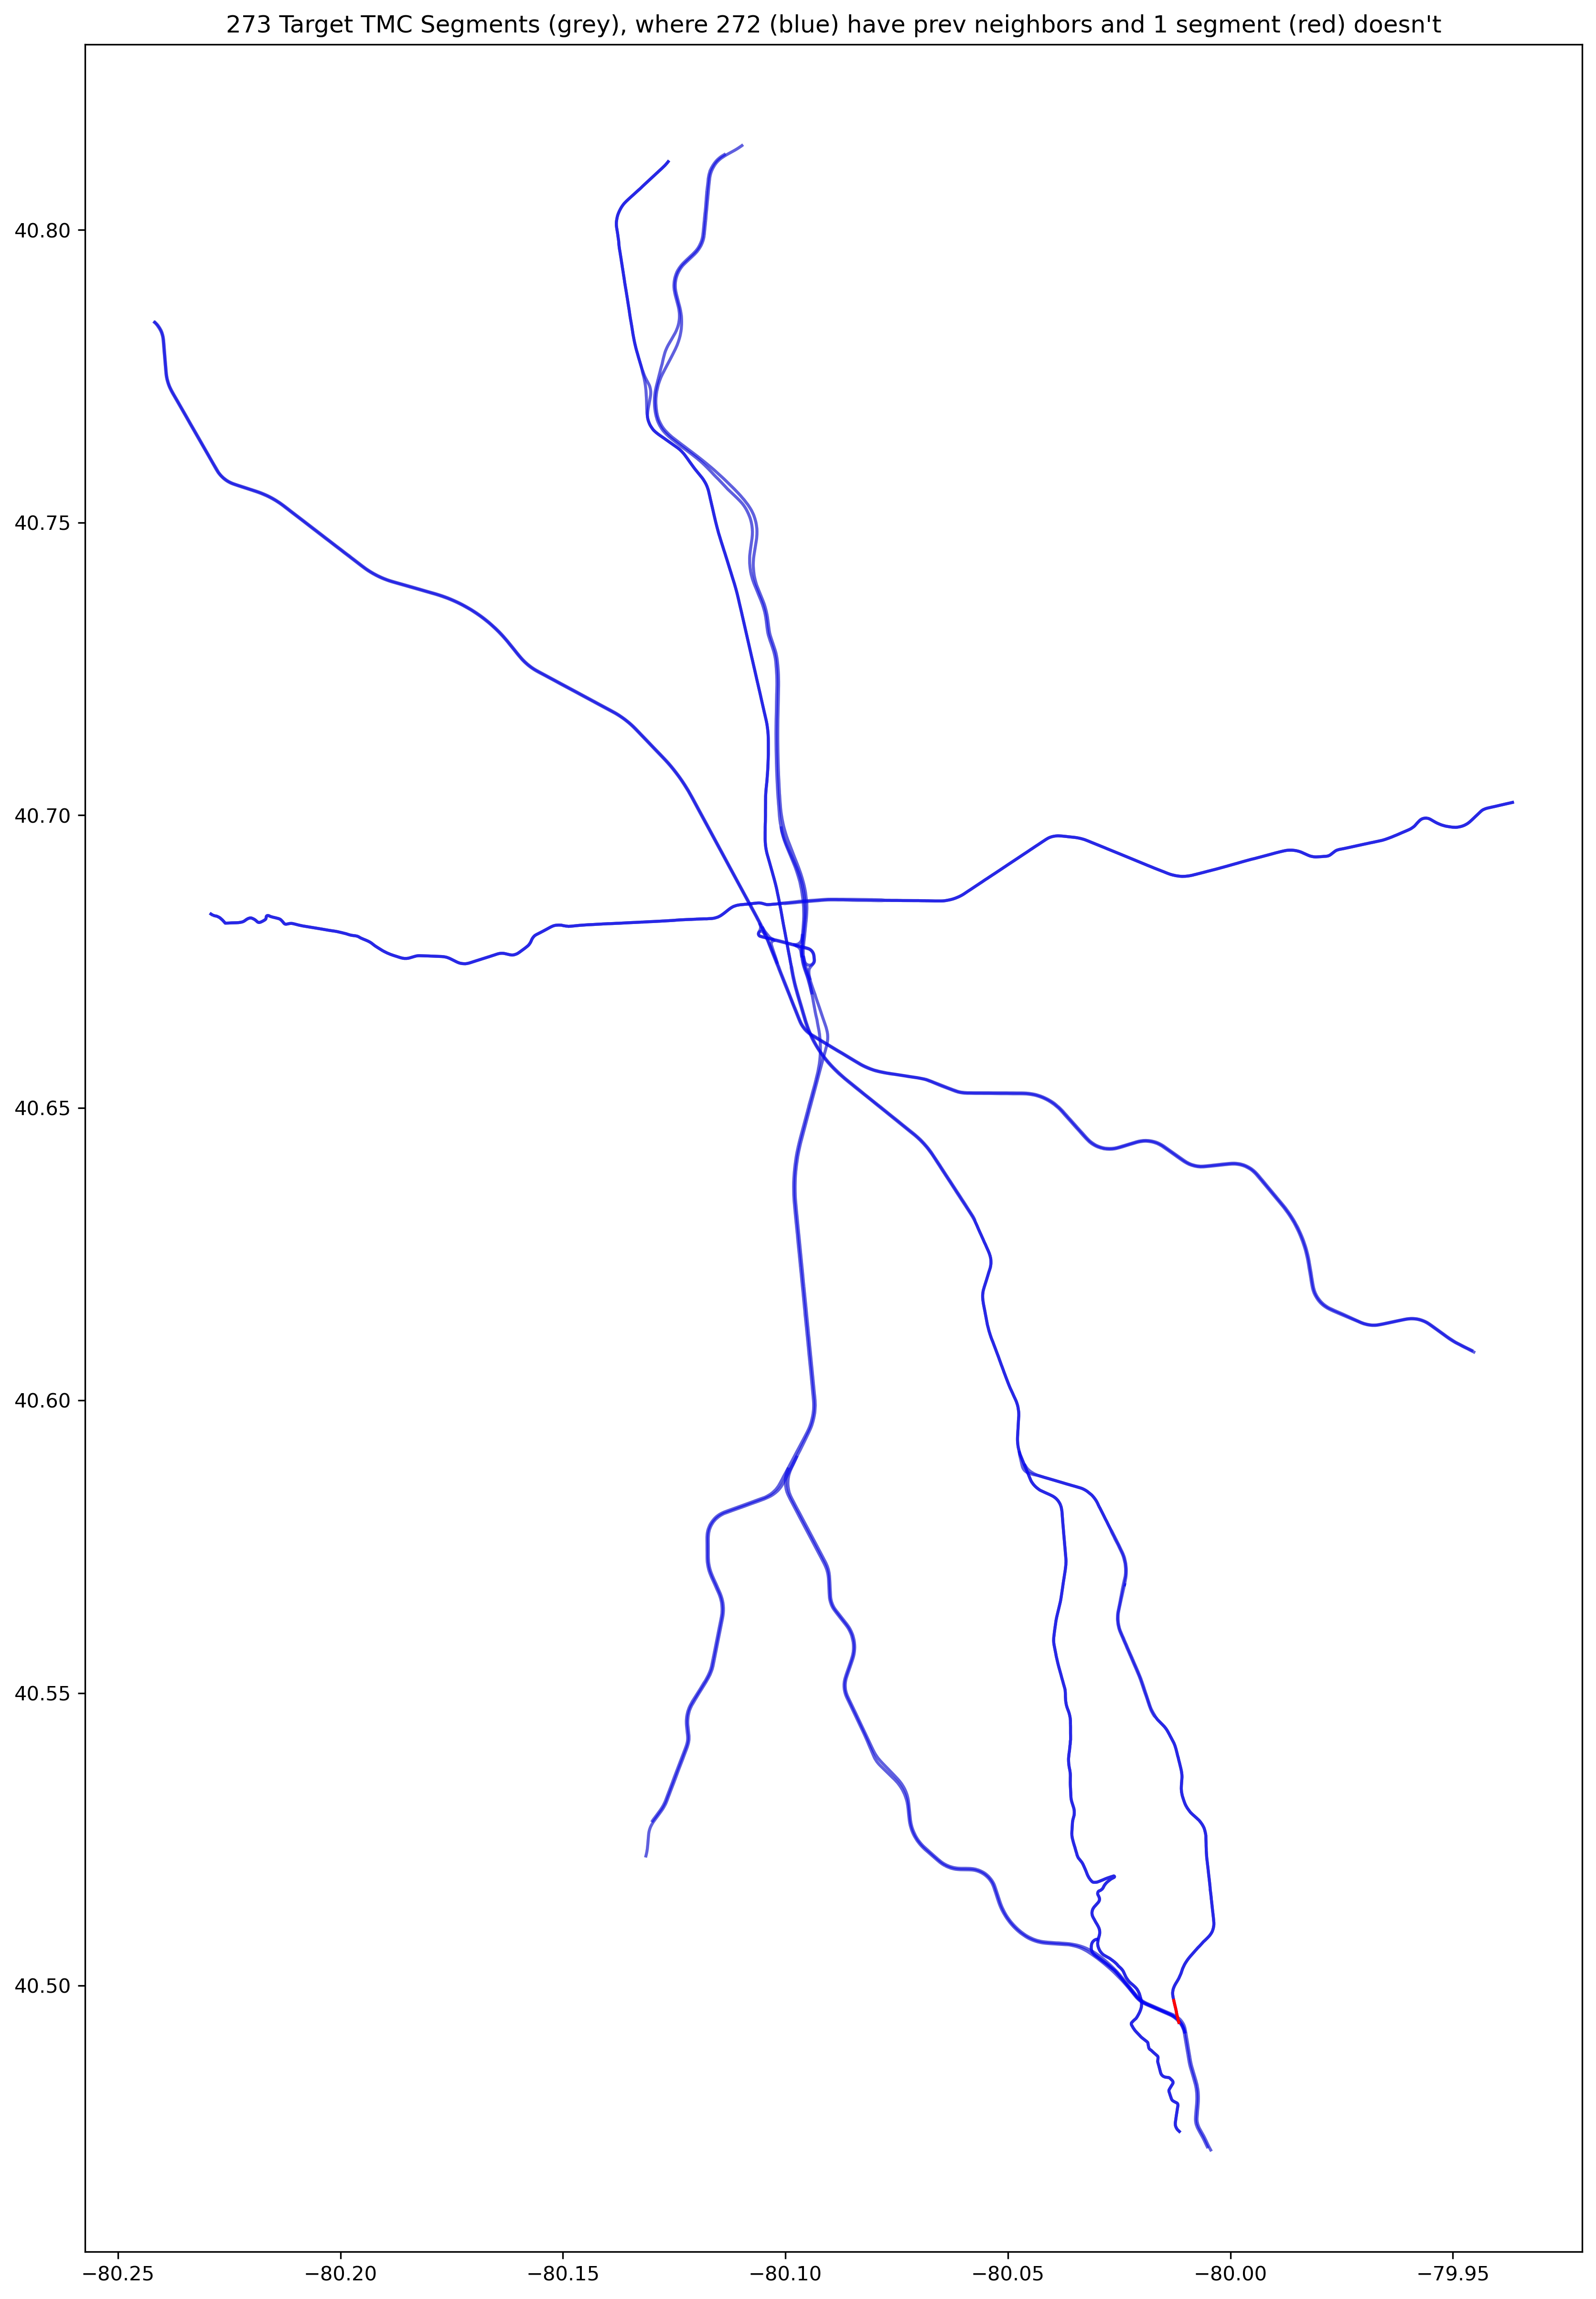

In [18]:
# Visualize and manually check segments without previous neighbors

# There are 15 segments without any immediate prev neighbor
# I have manually checked their neighbors on QGIS (with cranberry_tmc and PA_tmc), they either go missing in cranberry_tmc shapefile or lack speed data
print(set_tmc_segments_within_spd_shp_inc.difference(dict_prev_tmc)) 

fig, ax = plt.subplots(1,figsize=(30,20), dpi=300)
ax.set_title("273 Target TMC Segments (grey), where 272 (blue) have prev neighbors and 1 segment (red) doesn't")
# gdf_tmc_cranberry.plot(ax=ax, color="grey", alpha=0.1)
gdf_shp_tmc[gdf_shp_tmc.id_tmc.isin(set_tmc_segments_within_spd_shp_inc)].plot(ax=ax, color="grey", alpha=0.5)
gdf_shp_tmc[gdf_shp_tmc.id_tmc.isin(dict_prev_tmc)].plot(ax=ax, color="blue", alpha=0.5)
gdf_shp_tmc[(gdf_shp_tmc.id_tmc.isin(set_tmc_segments_within_spd_shp_inc)) & (~gdf_shp_tmc.id_tmc.isin(dict_prev_tmc))].plot(ax=ax, color="red")

In [25]:
with open("../../data/dict_prev_tmc_v2.pkl", "wb") as f:
    pickle.dump(dict_prev_tmc, f)

#### 1.2.2 Immediate Next Segment (TODO)

### 1.3 Calculate upstream and downstream neighbors for each TMC segment using their immediate prev and next

In [26]:
dict_upstream_tmc = {}
for source in tqdm(list(set_tmc_segments_within_spd_shp_inc)):
    dict_upstream_tmc[source] = compute_upstream(source=source, dict_prev=dict_prev_tmc, dict_upstream=dict_upstream_tmc)

100%|██████████| 273/273 [00:00<00:00, 152104.81it/s]


current tmc:  104N04528 358    SOUTHBOUND
Name: direction, dtype: object
upstream:  [['104-04528', '104N04529', '104-04529', '104N04530', '104-04530', '104N04531', '104-04531', '104N04532', '104-04532', '104N04533', '104N04440', '104-04440', '104N04441', '104-04441', '104N04442', '104-04442', '104N04443', '104-04443', '104N11466', '104-11466', '104N04444', '104-04444', '104N04445', '104-04445', '104N04782', '104-04782', '104N04783', '104-04783', '104N04784', '104-04784'], ['104-04528', '104N04529', '104-04529', '104N04530', '104-04530', '104N04531', '104-04531', '104N04532', '104-04532', '104N04533', '104N04440', '104-04440', '104N04441', '104-04441', '104N04442', '104-04442', '104N04443', '104-04443', '104P11616', '104P11624', '104N08677', '104-08677', '104-08678', '104N08679', '104P11630', '104P11628', '104+04541', '104P04540', '104+04540', '104P13683', '104+13683', '104P13682', '104+13682', '104P04539', '104+04539'], ['104-04528', '104N04529', '104-04529', '104N04530', '104-04530', 

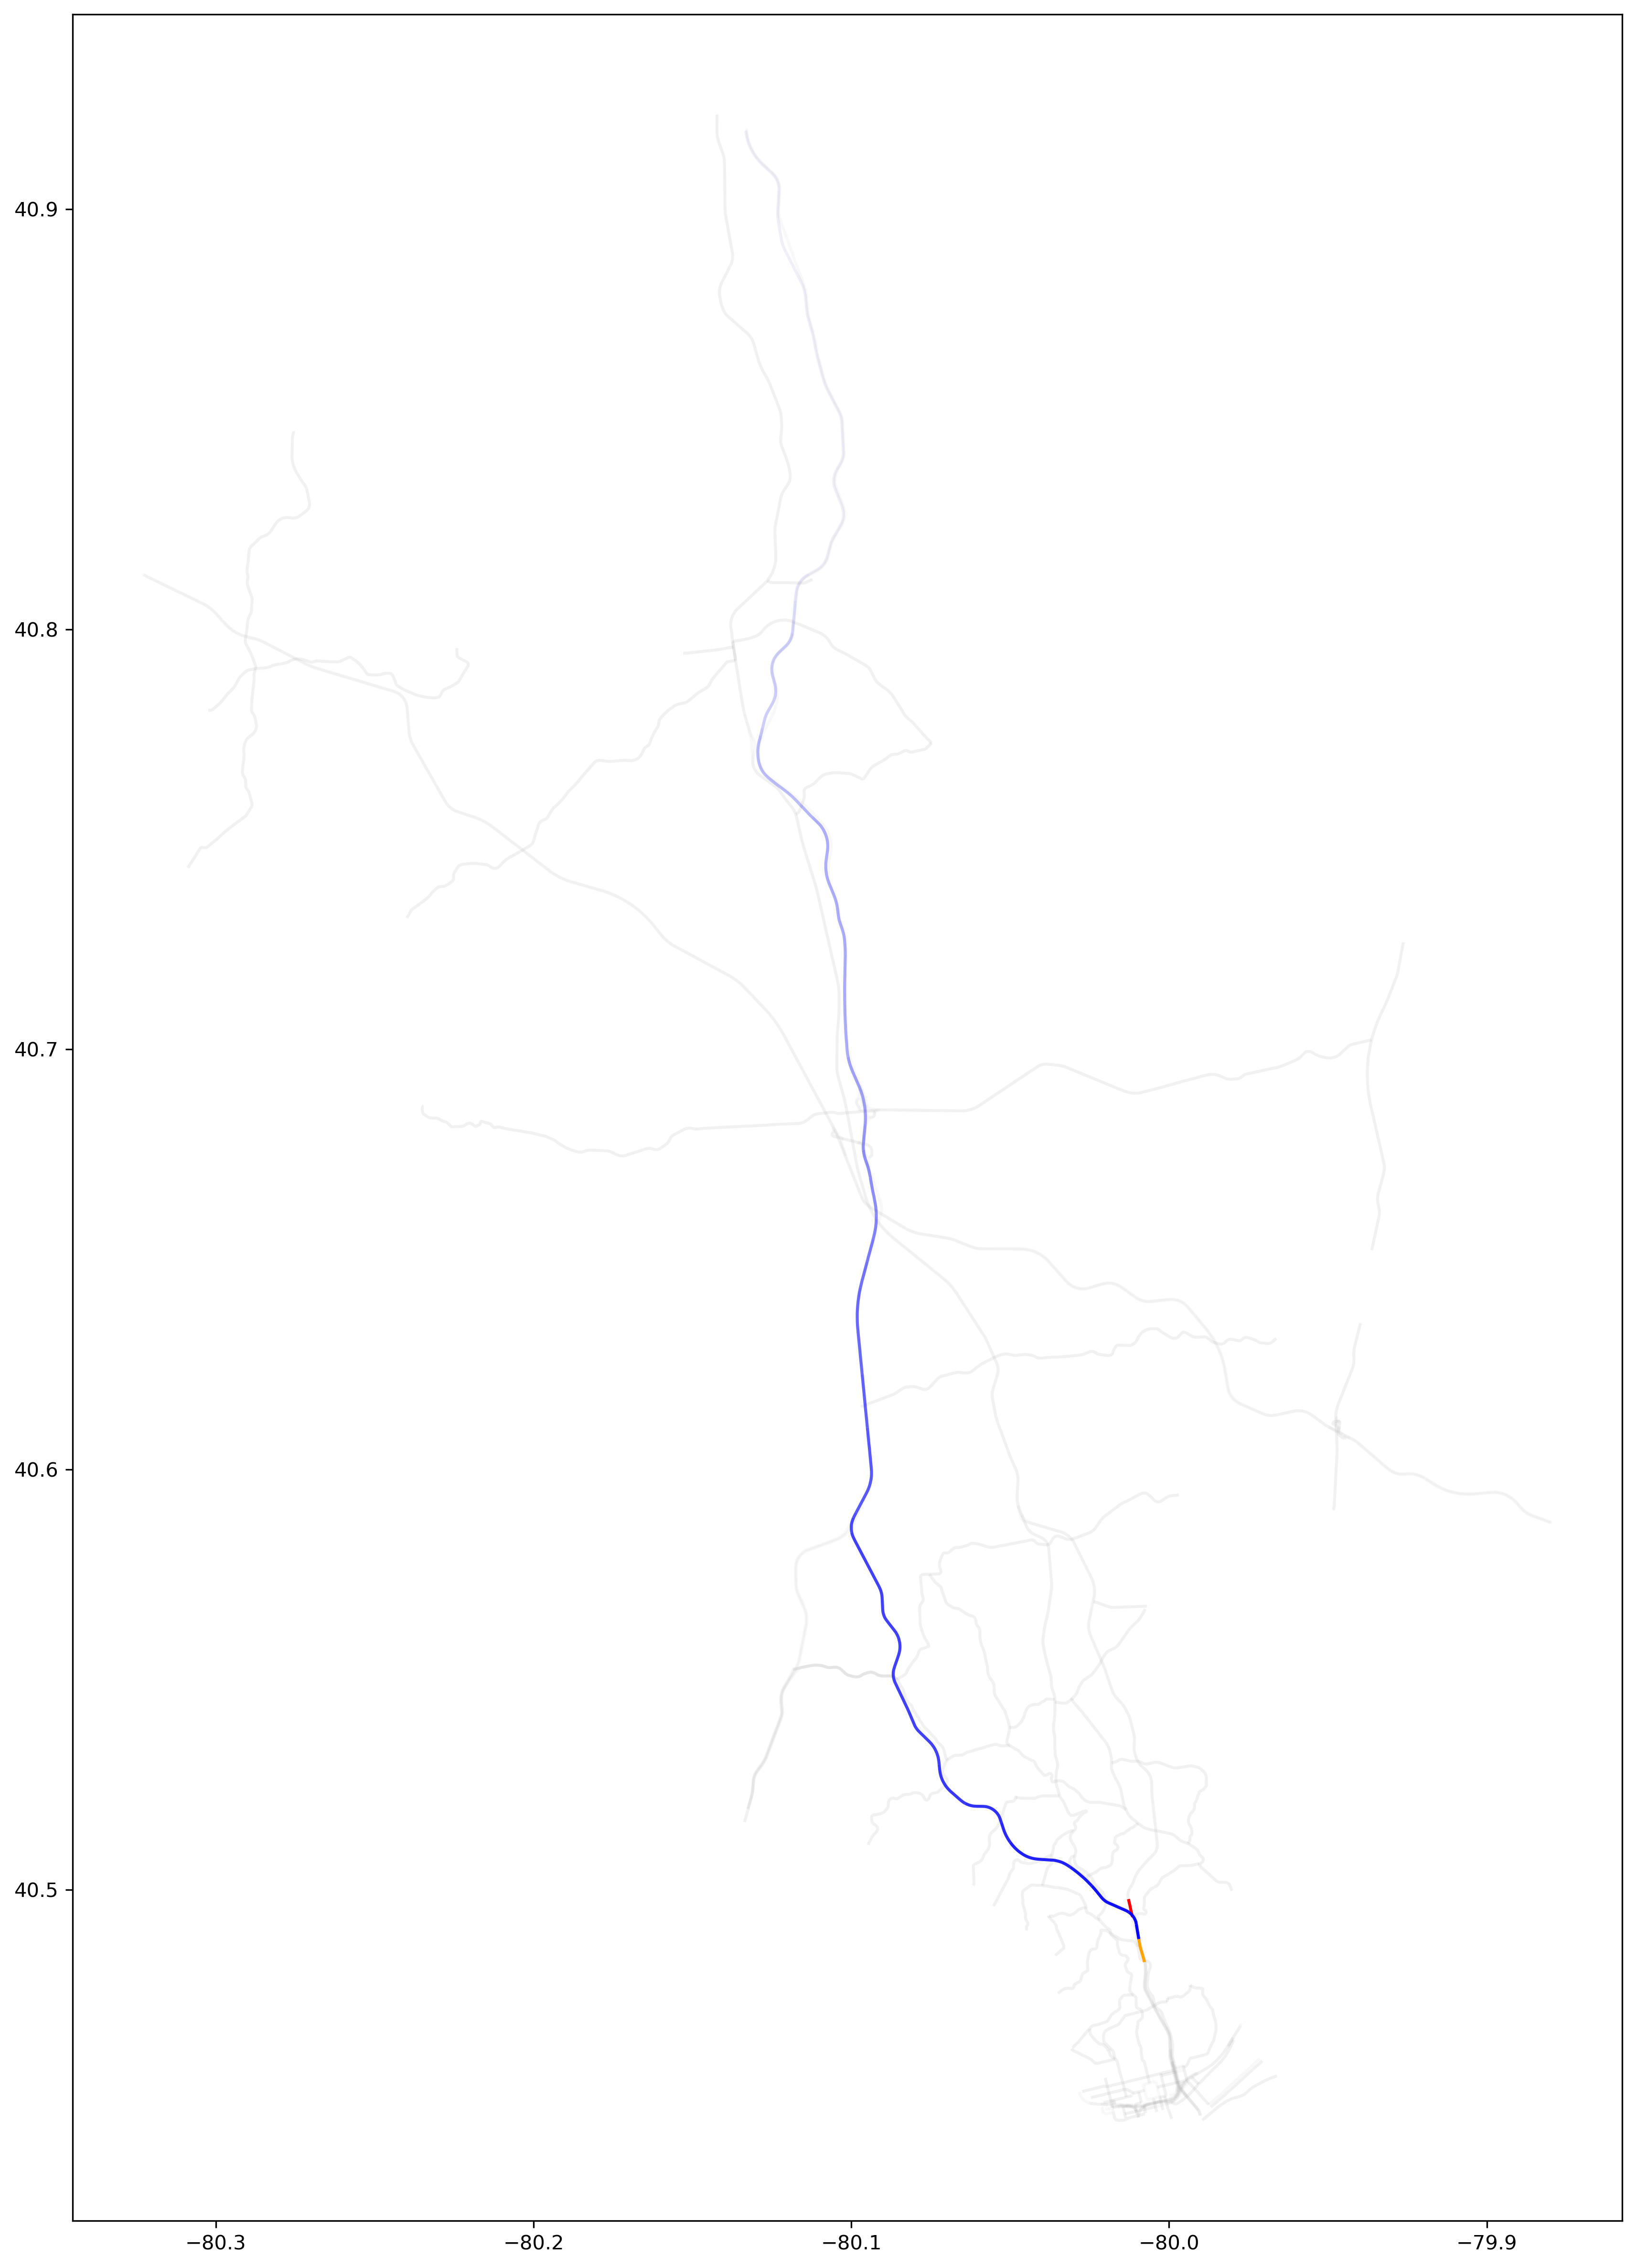

In [27]:
# Visualize and manually check upstream segments starting from each of 272 segments
i = 1
check_curr_tmc = list(set_tmc_segments_within_spd_shp_inc)[i]
print("current tmc: ", check_curr_tmc, gdf_shp_tmc[gdf_shp_tmc.id_tmc == check_curr_tmc].direction)
check_upstream = dict_upstream_tmc[check_curr_tmc]
print("upstream: ", check_upstream)
fig, ax = plt.subplots(1,figsize=(30,20), dpi=300)
gdf_shp_tmc.plot(ax=ax, color="grey", alpha=0.05) # entire TMC segments in cranberry 
gdf_shp_tmc[(gdf_shp_tmc.id_tmc.isin(set_tmc_segments_within_spd_shp_inc)) & (~gdf_shp_tmc.id_tmc.isin(dict_prev_tmc))].plot(ax=ax, color="red") # TMC segments without prev neighbors
gdf_shp_tmc[gdf_shp_tmc.id_tmc == check_curr_tmc].plot(ax=ax, color="orange") # source
if len(check_upstream) > 1:
    print(f"MORE THAN ONE UPSTREAM PATH!!! There are {len(check_upstream)} upstream paths")
j = 0
for k, u in enumerate(check_upstream[j]):
    gdf_shp_tmc[gdf_shp_tmc.id_tmc == u].plot(ax=ax, color="blue", alpha= (len(check_upstream[j])-k)/len(check_upstream[j]))  # upstream segments

In [28]:
with open("../../data/dict_upstream_tmc_v2.pkl", "wb") as f:
    pickle.dump(dict_upstream_tmc, f)

# 2. Limit Upstream within Range

In [29]:
# Generate upstream (within range) for each TMC segment
# Execution Time: instant
dict_upstream_tmc_within_range = {}
for tmc in tqdm(list(set_tmc_segments_within_spd_shp_inc)):
    if not dict_upstream_tmc[tmc][0]:
        dict_upstream_tmc_within_range[tmc] = [[]]
        continue
    else:
        dict_upstream_tmc_within_range[tmc] = []
        for upstream in dict_upstream_tmc[tmc]:
            dist = range
            i = 0
            while i < len(upstream) and dist >= 0:
                dist -= dict_miles_tmc[upstream[i]]
                i += 1
            dict_upstream_tmc_within_range[tmc] += [upstream[:i]]

100%|██████████| 273/273 [00:00<00:00, 63592.41it/s]


In [30]:
pickle.dump(dict_upstream_tmc_within_range, open("../../data/dict_upstream_tmc_5_miles_v2.pkl", "wb"))

# 3. Convert Dict of All Upstream List to Dict of Unique Upstream Segments

In [31]:
def convert_dict_upstream_to_dict_upstream_set(dict_upstream, set_segments):
    dict_upstream_set = {}
    for seg in tqdm(list(set_segments)):
        seg_upstream_list = []
        for upstream in dict_upstream[seg]:
            seg_upstream_list += upstream
        dict_upstream_set[seg] = set(seg_upstream_list)
    return dict_upstream_set

In [32]:
# dict_upstream_xd_str = pickle.load(open("../../data/dict_upstream_xd_str_v2.pkl", "rb"))
dict_upstream_tmc = pickle.load(open("../../data/dict_upstream_tmc_v2.pkl", "rb"))
# dict_upstream_xd_str_5_miles = pickle.load(open("../../data/dict_upstream_xd_str_5_miles_v2.pkl", "rb"))
dict_upstream_tmc_5_miles = pickle.load(open("../../data/dict_upstream_tmc_5_miles_v2.pkl", "rb"))

In [33]:
set_tmc_segments_for_upstream = pickle.load(open("./set_tmc_segments_within_spd_shp_inc.pkl", "rb"))
# set_xd_segments_str_for_upstream = pickle.load(open("./set_xd_segments_str_for_upstream.pkl", "rb"))

In [34]:
dict_upstream_unique_tmc = convert_dict_upstream_to_dict_upstream_set(dict_upstream_tmc, set_tmc_segments_for_upstream)
# dict_upstream_unique_xd_str = convert_dict_upstream_to_dict_upstream_set(dict_upstream_xd_str, set_xd_segments_str_for_upstream)
dict_upstream_unique_tmc_5_miles = convert_dict_upstream_to_dict_upstream_set(dict_upstream_tmc_5_miles, set_tmc_segments_for_upstream)
# dict_upstream_unique_xd_str_5_miles = convert_dict_upstream_to_dict_upstream_set(dict_upstream_xd_str_5_miles, set_xd_segments_str_for_upstream)

100%|██████████| 273/273 [00:00<00:00, 362012.33it/s]


In [35]:
pickle.dump(dict_upstream_unique_tmc, open("../../data/dict_upstream_unique_tmc_v2.pkl", "wb"))
# pickle.dump(dict_upstream_unique_xd_str, open("../../data/dict_upstream_unique_xd_str.pkl", "wb"))
pickle.dump(dict_upstream_unique_tmc_5_miles, open("../../data/dict_upstream_unique_tmc_5_miles_v2.pkl", "wb"))
# pickle.dump(dict_upstream_unique_xd_str_5_miles, open("../../data/dict_upstream_unique_xd_str_5_miles.pkl", "wb"))